<a href="https://colab.research.google.com/github/atikhasan007/Scikit-learn/blob/main/final_code123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sengulgs_whu_building_dataset_path = kagglehub.dataset_download('sengulgs/whu-building-dataset')
mdrifaturrahman33_levir_cd_change_detection_path = kagglehub.dataset_download('mdrifaturrahman33/levir-cd-change-detection')
mdrifaturrahman33_s2_looking_path = kagglehub.dataset_download('mdrifaturrahman33/s2-looking')

print('Data source import complete.')


In [ ]:
LEVIR = "/kaggle/input/levir-cd-change-detection/LEVIR-CD+"
S2    = "/kaggle/input/s2-looking/S2Looking"
WHU   = "/kaggle/input/whu-building-dataset/WHU"


✅ Total samples collected: 14173


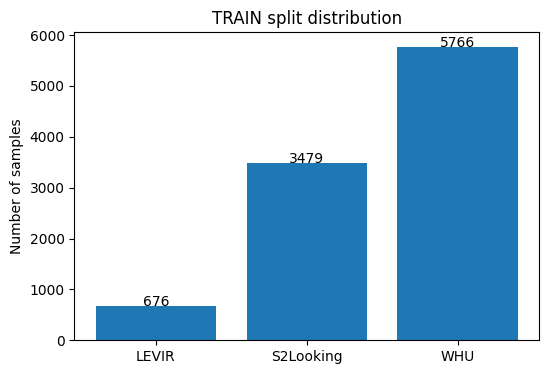

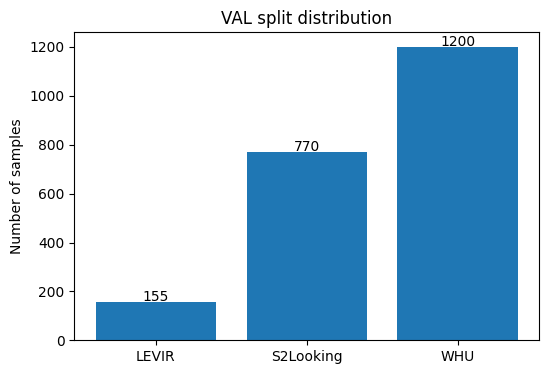

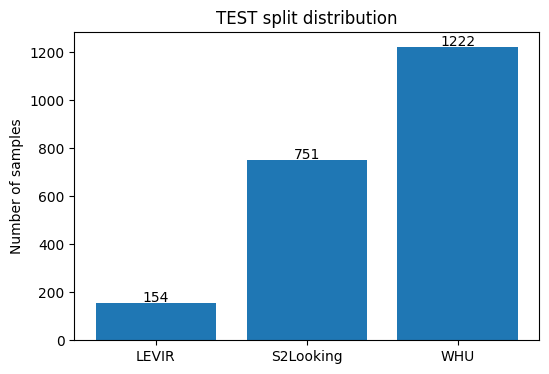

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from collections import Counter

# --- Source Paths ---
LEVIR = "/kaggle/input/levir-cd-change-detection/LEVIR-CD+"
S2    = "/kaggle/input/s2-looking/S2Looking"
WHU   = "/kaggle/input/whu-building-dataset/WHU"

# -------------------------------
# Collect all samples (paths only, no os.path.exists check)
# -------------------------------
samples = []

# LEVIR
for split in ["train", "test"]:
    pathA = os.path.join(LEVIR, split, "A")
    pathB = os.path.join(LEVIR, split, "B")
    pathL = os.path.join(LEVIR, split, "label")
    if os.path.exists(pathA):
        for fname in os.listdir(pathA):
            samples.append((os.path.join(pathA,fname),
                            os.path.join(pathB,fname),
                            os.path.join(pathL,fname),
                            "levir"))

# S2Looking
for split in ["train", "val", "test"]:
    pathA = os.path.join(S2, split, "Image1")
    pathB = os.path.join(S2, split, "Image2")
    lbl_dirs = [os.path.join(S2, split, d) for d in ["label", "label1", "label2"]]
    if os.path.exists(pathA):
        for fname in os.listdir(pathA):
            label = next((os.path.join(d,fname) for d in lbl_dirs), None)
            samples.append((os.path.join(pathA,fname),
                            os.path.join(pathB,fname),
                            label,
                            "s2"))

# WHU
for split in ["train", "val", "test"]:
    pathA = os.path.join(WHU, split, "Image")
    pathL = os.path.join(WHU, split, "Mask")
    if os.path.exists(pathA):
        for fname in os.listdir(pathA):
            samples.append((os.path.join(pathA,fname),
                            os.path.join(pathA,fname),  # A=B
                            os.path.join(pathL,fname),
                            "whu"))

print(f"✅ Total samples collected: {len(samples)}")

# -------------------------------
# Shuffle & Split 70/15/15
# -------------------------------
random.shuffle(samples)
n = len(samples)
n_train = int(0.7*n)
n_val   = int(0.15*n)

splits = {
    "train": samples[:n_train],
    "val":   samples[n_train:n_train+n_val],
    "test":  samples[n_train+n_val:]
}

# -------------------------------
# Analyze imbalance (source-wise)
# -------------------------------
counts = {split: Counter([src for *_, src in items]) for split, items in splits.items()}

for split in ["train","val","test"]:
    plt.figure(figsize=(6,4))
    vals = [counts[split].get(s,0) for s in ["levir","s2","whu"]]
    plt.bar(["LEVIR","S2Looking","WHU"], vals)
    plt.title(f"{split.upper()} split distribution")
    plt.ylabel("Number of samples")
    for i,v in enumerate(vals):
        plt.text(i, v+5, str(v), ha='center')
    plt.show()


Total samples: 14173
Train samples: 9921
Validation samples: 2125
Test samples: 2127


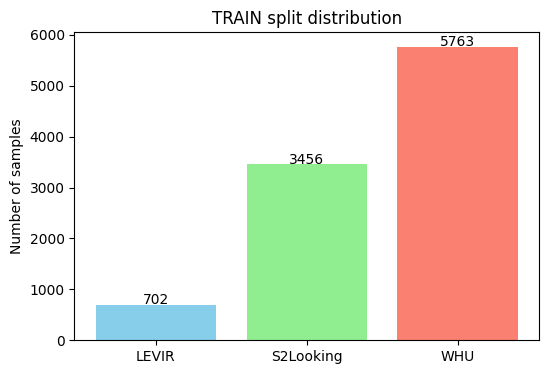

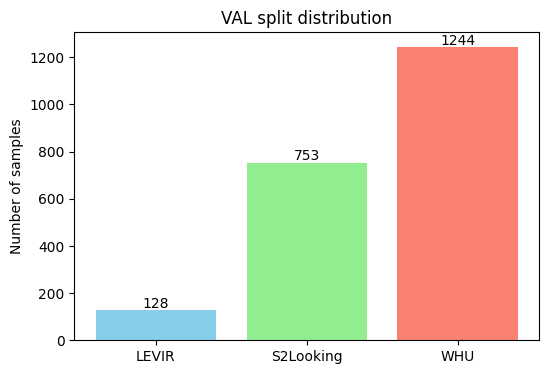

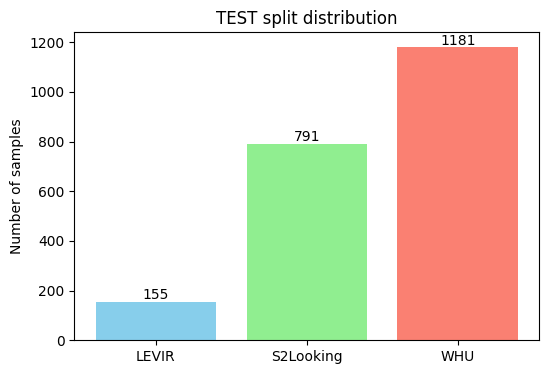

In [ ]:
import random
import matplotlib.pyplot as plt
from collections import Counter

# ধরা হলো samples = 14173 (আগের code থেকে এসেছে)
n = len(samples)
n_train = int(0.7 * n)   # 70%
n_val   = int(0.15 * n)  # 15%
n_test  = n - n_train - n_val  # বাকি 15%

print(f"Total samples: {n}")
print(f"Train samples: {n_train}")
print(f"Validation samples: {n_val}")
print(f"Test samples: {n_test}")

# Shuffle & split
random.shuffle(samples)
splits = {
    "train": samples[:n_train],
    "val":   samples[n_train:n_train+n_val],
    "test":  samples[n_train+n_val:]
}

# Source-wise distribution graph
counts = {split: Counter([src for *_, src in items]) for split, items in splits.items()}

for split in ["train","val","test"]:
    plt.figure(figsize=(6,4))
    vals = [counts[split].get(s,0) for s in ["levir","s2","whu"]]
    plt.bar(["LEVIR","S2Looking","WHU"], vals, color=["skyblue","lightgreen","salmon"])
    plt.title(f"{split.upper()} split distribution")
    plt.ylabel("Number of samples")
    for i,v in enumerate(vals):
        plt.text(i, v+10, str(v), ha='center')
    plt.show()


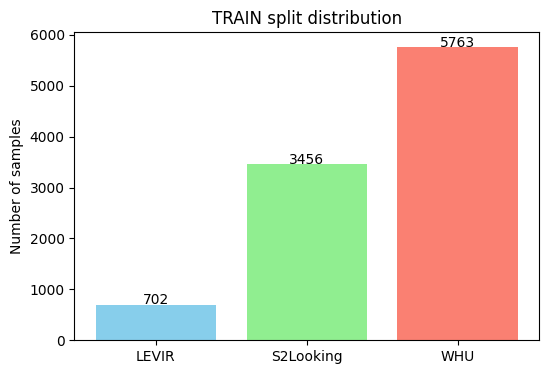

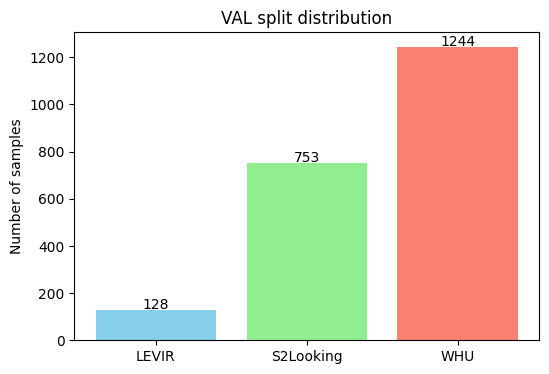

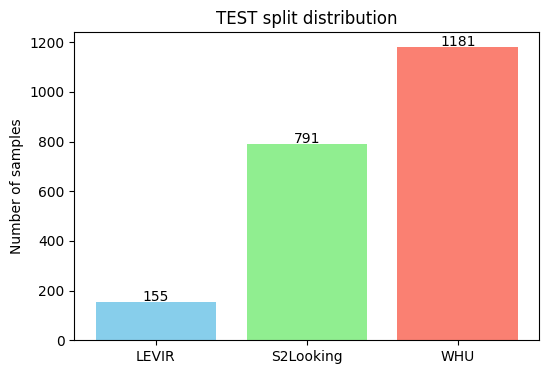

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# -------------------------------
# source-wise count
# -------------------------------
counts = {split: Counter([src for *_, src in items]) for split, items in splits.items()}

for split in ["train","val","test"]:
    plt.figure(figsize=(6,4))
    vals = [counts[split].get(s,0) for s in ["levir","s2","whu"]]
    plt.bar(["LEVIR","S2Looking","WHU"], vals, color=['skyblue','lightgreen','salmon'])
    plt.title(f"{split.upper()} split distribution")
    plt.ylabel("Number of samples")
    for i,v in enumerate(vals):
        plt.text(i, v+5, str(v), ha='center', fontsize=10)
    plt.show()


In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class ChangeDetectionDataset(Dataset):
    def __init__(self, samples_list, transform=None):
        """
        samples_list: list of tuples (img1_path, img2_path, mask_path, source)
        """
        self.samples = samples_list
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img1_path, img2_path, mask_path, _ = self.samples[idx]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            # Apply transformation only to images
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        # Convert mask to a tensor and adjust shape
        mask = torch.from_numpy(np.array(mask)).long()
        # We can use a simple average or check for any change to create a single label per image pair
        # For simplicity, let's assume any change in the mask means a 'change' for the whole image pair.
        # This simplifies the problem to image pair classification, not pixel-wise segmentation.
        # If pixel-wise is needed, the model and loss need to be adjusted.
        if mask.max() > 0:
            label = torch.tensor(1) # Change detected
        else:
            label = torch.tensor(0) # No change detected


        return img1, img2, label

In [ ]:
from torch.utils.data import DataLoader

train_dataset = ChangeDetectionDataset(splits["train"], transform=transform)
val_dataset   = ChangeDetectionDataset(splits["val"], transform=transform)
test_dataset  = ChangeDetectionDataset(splits["test"], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 9921
Validation samples: 2125
Test samples: 2127


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score


In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return x * self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return x * self.sigmoid(self.conv(x_cat))

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.channel_att = ChannelAttention(in_channels, reduction)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x


In [ ]:
class SiameseCBAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 32, 3, padding=1)  # 3+3 channels
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.cbam1 = CBAM(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.cbam2 = CBAM(64)

        self.fc = nn.Sequential(
            nn.Linear(64*64*64, 256),  # input image 256x256
            nn.ReLU(),
            nn.Linear(256, 2)  # 2 classes: change / no-change
        )

    def forward(self, imgA, imgB):
        x = torch.cat([imgA, imgB], dim=1)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.cbam1(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.cbam2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseCBAM().to(device)

criterion = nn.CrossEntropyLoss()  # For class imbalance, we can add weights if needed
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import torch
from torch.optim import lr_scheduler

num_epochs = 50  # কিছু বেশি দিন, EarlyStopping handle করবে
patience = 5  # কত epoch ধরে improvement না হলে stop হবে
best_val_f1 = 0
trigger_times = 0

# Optional: Learning rate decay
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for imgA, imgB, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        imgA, imgB, labels = imgA.to(device), imgB.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgA, imgB)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgA.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for imgA, imgB, labels in val_loader:
            imgA, imgB, labels = imgA.to(device), imgB.to(device), labels.to(device)
            outputs = model(imgA, imgB)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    train_acc = train_correct / train_total
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    # Learning rate decay
    scheduler.step()

    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Training Epoch 1: 100%|██████████| 2481/2481 [07:28<00:00,  5.54it/s]


Epoch 1: Train Acc: 0.9105, Val Acc: 0.9421, Val F1: 0.9682


Training Epoch 2: 100%|██████████| 2481/2481 [04:43<00:00,  8.75it/s]


Epoch 2: Train Acc: 0.9392, Val Acc: 0.9412, Val F1: 0.9668


Training Epoch 3: 100%|██████████| 2481/2481 [04:45<00:00,  8.69it/s]


Epoch 3: Train Acc: 0.9491, Val Acc: 0.9553, Val F1: 0.9754


Training Epoch 4: 100%|██████████| 2481/2481 [04:50<00:00,  8.54it/s]


Epoch 4: Train Acc: 0.9544, Val Acc: 0.9501, Val F1: 0.9728


Training Epoch 5: 100%|██████████| 2481/2481 [04:50<00:00,  8.54it/s]


Epoch 5: Train Acc: 0.9601, Val Acc: 0.9548, Val F1: 0.9749


Training Epoch 6: 100%|██████████| 2481/2481 [04:50<00:00,  8.53it/s]


Epoch 6: Train Acc: 0.9708, Val Acc: 0.9529, Val F1: 0.9739


Training Epoch 7: 100%|██████████| 2481/2481 [04:49<00:00,  8.57it/s]


Epoch 7: Train Acc: 0.9799, Val Acc: 0.9511, Val F1: 0.9726


Training Epoch 8: 100%|██████████| 2481/2481 [04:50<00:00,  8.55it/s]


Epoch 8: Train Acc: 0.9840, Val Acc: 0.8936, Val F1: 0.9380
Early stopping at epoch 8


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


SiameseCBAM(
  (conv1): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cbam1): CBAM(
    (channel_att): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (fc): Sequential(
        (0): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ReLU()
        (2): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (sigmoid): Sigmoid()
    )
    (spatial_att): SpatialAttention(
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cbam2): CBAM(
    (channel_att): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (fc): Sequential(

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_preds, test_labels = [], []
with torch.no_grad():
    for imgA, imgB, labels in test_loader:  # আলাদা test_loader থাকতে হবে
        imgA, imgB, labels = imgA.to(device), imgB.to(device), labels.to(device)
        outputs = model(imgA, imgB)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print("Classification Report:\n", classification_report(test_labels, test_preds))
print("Confusion Matrix:\n", confusion_matrix(test_labels, test_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.77       200
           1       0.97      0.98      0.98      1927

    accuracy                           0.96      2127
   macro avg       0.89      0.86      0.87      2127
weighted avg       0.96      0.96      0.96      2127

Confusion Matrix:
 [[ 147   53]
 [  37 1890]]


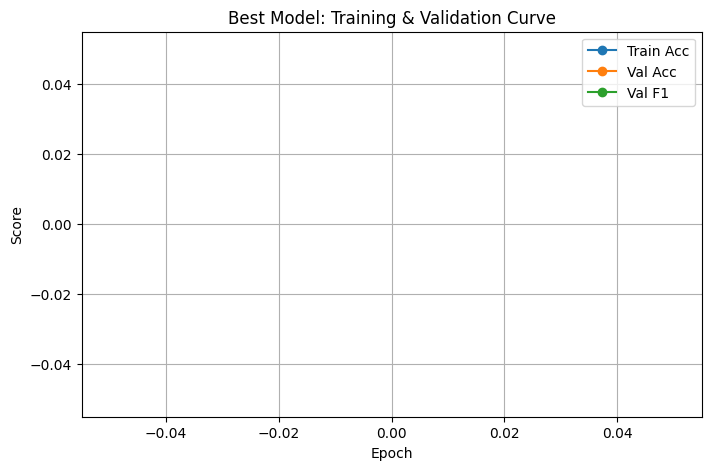

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_acc_list, label="Train Acc", marker='o')
plt.plot(val_acc_list, label="Val Acc", marker='o')
plt.plot(val_f1_list, label="Val F1", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Best Model: Training & Validation Curve")
plt.legend()
plt.grid(True)
plt.show()
